In [1]:
import os 
import re 
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import urllib.request as ur
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

from konlpy.tag import Okt
from collections import Counter

import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import random
import datetime

from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import nltk 
from nltk.corpus import stopwords
import matplotlib
from IPython.display import set_matplotlib_formats
from wordcloud import WordCloud


In [2]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [3]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    
    b_input_ids = torch.tensor(b_input_ids).to(device).long()
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
        

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [328]:
browser = webdriver.Chrome("C:/jupyter/chromedriver.exe")


# browser.get("https://www.yogiyo.co.kr/mobile/#/13338/")

browser.get("https://www.yogiyo.co.kr/mobile/#/469202/")

browser.maximize_window()
time.sleep(2)
elem = browser.find_element_by_xpath("//*[@id='content']/div[2]/div[1]/ul/li[2]/a")
elem.click()

elem = browser.find_element_by_xpath("//*[@id='review']/li[12]")

# 화면 가장 아래로 스크롤 내리기
browser.execute_script("window.scrollTo(0, document.body.scrollHeight)")

interval = 2 # 2초에 한번씩 스크롤 내림

# 현재 문서 높이를 가져와서 저장
prev_height = browser.execute_script("return document.body.scrollHeight")

# 반복 수행
while True:
    # 스크롤을 가장 아래로 내림
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    try:
        elem.click()
    except:
        pass
    
    # 페이지 로딩 대기
    time.sleep(interval)


    # 현재 문서 높이를 가져와서 저장
    curr_height = browser.execute_script("return document.body.scrollHeight")
    if curr_height == prev_height:
        break

    prev_height = curr_height

print("스크롤 완료")

스크롤 완료


In [329]:
soup = bs(browser.page_source, "lxml")
# page_source로 스크롤 끝까지 내렸을 때의 html 정보를 가져오게 됨

# 정보) 속성을 리스트로 감싸주어 조건을 만족하는 모든 데이터를 가져올 수 있다.
# reviews = soup.find_all("div", attrs={"class":["ImZGtf mpg5gc", "Vpfmgd"]})
reviews = soup.find_all("li", attrs={"class": "list-group-item star-point ng-scope"})
print(len(reviews))
total_average = 0 # 리뷰 전체 평균
taste_average = 0 # 맛 전체 평균
quantity_average = 0 # 양 전체 평균
delivery_average = 0 # 배달 전체 평균


comments = []

for review in reviews:
    comment = review.find("p", attrs={"class": "ng-binding", "ng-show":"review.comment"}).text
    
    comments.append(comment)

print(comments)

763
['정말맛있게먹었어요다음에는사진도올릴게요', '맛있게 잘 먹었어요. 새우가 탱글하니 신선함이 느껴집니다^^', '통통한팬피자...도우도맛있거  급히먹느라  사진깜박이지만  반반메뉴 너무좋아요 토핑도 듬뿍이라  좋아요^^', '매번 먹는곳이지만\n너무맛있게먹다보니 오자마자 사진찍는걸 까먹었어요ㅎㅎ\n진짜 이집 피자는 굳입니다', '너무 맛있었어요', '너무 맛있게 잘 먹었어요!!', '역시 피자앰소마 별점에는 이유가 있는법\n존맛탱ㅎ', '배달 빨라서 따뜻하고 좋네요', '피자가 한쪽으로 쏠려왔어요.... 하지만 맛있어서 먹었습니다 ㅋㅋ', '맛있었고 페페로니는처음인대 전콤비가더맛있는듯', '항상 시켜먹는 피자집이지만\n배달도 빠르고 너무 맛있네요 ^^ 너무너무 좋아요☺️😍', '맛나게 잘먹었습니다~~~', '맛잇게 먹었습니다.\n친절하게 안내해줘서 감사합니다.', '피자 엄청 빨리 왓는데 조금 찌그러졋네요♡서비스로 주신 샐러드도 굿이엿어요!가족 모두 잘먹엇습니당!번창하세요', '배달은 예상시간보고 훨씬 빨랐구요~\n리뷰보고 첫주문인데~^^맛나네요~~~~\n한끼 식사로 충분했습니다!!!', '맛있습니다 특히 소수가 많아서 좋아요', '맛있게 먹었어요 소스도 다양하고 치즈가 듬뿍있엇어요', '새우가 실하코 통통해서 씹는맛이 좋네요', '배송도 생각보다 빠르고, 양도 많아서 좋아요☺💕💕\n배달원 분도 친절하셔서 기분좋게 먹었네요😁', '완전 맛있어 요  고기 딱  식감 좋고요  새우도 부드러워요  ㅋㅋㅋ', '매번 피자는 무조건 여기라ㅎ 피자사진이 폰에 한가득이네요~\n역시나 변하지않는 맛과 신경써주시는 서비스에 맛있게 잘 먹었습ㄴ다', '요즘 이 피자에 꽂혀서 먹고있는데 진짜 너무 맛있고 앞으로도 지금의 맛 부탁드려요\n그리고 리뷰서비스도 다양해서 좋은거 같아요', '양과 맛 퀄리티 좋습니다!!', '그 유명한 엠소마 피자 이름값하네요!! 맛있네요~! 서비스도 굳굳!', '어우~ 오늘도 맛나게 먹어요 ㅎㅎ', '남아서 다음날 에프 돌려먹었는데도 맛있어요 ~

In [330]:
len(comments)

763

In [331]:
comments[0]

'정말맛있게먹었어요다음에는사진도올릴게요'

In [332]:
okt = Okt() 
morphs = [] 
for sentence in comments: 
    morphs.append(okt.pos(sentence)) 
    
print(morphs)


[[('정말', 'Noun'), ('맛있게', 'Adjective'), ('먹었어요', 'Verb'), ('다음', 'Noun'), ('에는', 'Josa'), ('사진', 'Noun'), ('도', 'Josa'), ('올릴게요', 'Verb')], [('맛있게', 'Adjective'), ('잘', 'Verb'), ('먹었어요', 'Verb'), ('.', 'Punctuation'), ('새우', 'Noun'), ('가', 'Josa'), ('탱', 'Adverb'), ('글', 'Noun'), ('하', 'Suffix'), ('니', 'Josa'), ('신선함이', 'Adjective'), ('느껴집니다', 'Verb'), ('^^', 'Punctuation')], [('통통한', 'Adjective'), ('팬', 'Noun'), ('피자', 'Noun'), ('...', 'Punctuation'), ('도우', 'Noun'), ('도', 'Josa'), ('맛있거', 'Adjective'), ('급히', 'Adjective'), ('먹느라', 'Verb'), ('사진', 'Noun'), ('깜박', 'Noun'), ('이지만', 'Josa'), ('반', 'Modifier'), ('반', 'Modifier'), ('메뉴', 'Noun'), ('너무', 'Adverb'), ('좋아요', 'Adjective'), ('토핑', 'Noun'), ('도', 'Josa'), ('듬뿍', 'Noun'), ('이라', 'Josa'), ('좋아요', 'Adjective'), ('^^', 'Punctuation')], [('매번', 'Noun'), ('먹는', 'Verb'), ('곳', 'Noun'), ('이지만', 'Josa'), ('\n', 'Foreign'), ('너무', 'Adverb'), ('맛있게', 'Adjective'), ('먹다', 'Verb'), ('보니', 'Verb'), ('오', 'Modifier'), ('자마자', 'Noun'), ('사진', '

In [333]:
filter_words = ["다만", "껀", "먹기", "전체", "한지", "온", "생각", "별로", "맛", "배달", "도", "애", "두", "앞", "용", "때", "무조건", "좀", "꼭", "아주", "일단", "원래", "또", "것", "내", "나", "수", "게", "말", "진짜", "제일", "최고", "처음", "것", "정말", "이벤트", "매우", "번", "그냥", "이용"]

noun_adj_adv_list=[]

for sentence in morphs : 
    for word, tag in sentence : 
        if tag in ['Noun'] and word not in filter_words: 
            noun_adj_adv_list.append(word) 
            
print(noun_adj_adv_list)

# noun_adj_adv_list=[] 

# for sentence in morphs : 
#     for word, tag in sentence : 
#         if tag in ['Noun'] and ("꼭" not in word) and ("담" not in word) and ("이벤트" not in word) and ("원래" not in word) and ("역시" not in word) and ("곳" not in word) and ("오늘" not in word) and ("더" not in word) and ("진짜" not in word) and ("또" not in word) and ("다음" not in word) and ("제일" not in word) and ("항상" not in word) and ("처음" not in word) and ("좀" not in word) and ("것" not in word) and ("내" not in word) and ("나" not in word)and ("수"not in word) and("게"not in word)and("말"not in word): 
#             noun_adj_adv_list.append(word) 
            
# print(noun_adj_adv_list)


['다음', '사진', '새우', '글', '팬', '피자', '도우', '사진', '깜박', '메뉴', '토핑', '듬뿍', '매번', '곳', '자마자', '사진', '이집', '피자', '역시', '피자', '앰', '소마', '점', '이유', '법', '존맛', '빨', '피자', '한쪽', '페페로니', '인대', '콤비', '항상', '피자', '집', '안내', '피자', '왓는데', '조금', '찌', '졋', '서비스', '주신', '샐러드', '굿', '어요', '가족', '모두', '엇습', '번창', '예상', '시간', '보고', '리뷰', '보고', '주문', '끼', '식사', '소수', '소스', '치즈', '듬뿍', '있엇', '새우', '코', '배송', '양도', '분도', '기분', '완전', '요', '고기', '식감', '매번', '피자', '여기', '피자', '사진', '폰', '가득', '요', '역시', '신경', '서비스', '습', '요즘', '이', '피자', '지금', '리뷰', '서비스', '거', '양', '퀄리티', '그', '엠', '소마', '피자', '이름', '값', '서비스', '어우', '오늘', '남아', '다음', '날', '에프', '항상', '양도', '항상', '오늘', '피클', '소스', '하나', '다음', '리뷰', '평점', '양도', '매번', '치즈', '요', '항상', '리뷰', '스파게티', '피자', '치즈', '토핑', '피자', '조각', '사진', '페퍼로니', '킬러', '남친', '페퍼', '엣지', '추가', '저', '느을', '치즈', '스티', '추가', '오늘', '주문', '소스', '항상', '피자', '늘', '엠소마', '다음', '피자', '최고점', '치킨', '냄새', '전혀', '뼈', '하얀색', '스파게티', '스파게티', '전문점', '해도', '정도', '임', '가지', '피자', '추천', '시간', '해주시', '피자

In [334]:
count = Counter(noun_adj_adv_list)

In [335]:
words = dict(count.most_common())


In [336]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import nltk 
from nltk.corpus import stopwords
import matplotlib
from IPython.display import set_matplotlib_formats


In [337]:
%matplotlib inline

import matplotlib
from IPython.display import set_matplotlib_formats
matplotlib.rc('font',family = 'Malgun Gothic')
set_matplotlib_formats('retina')
matplotlib.rc('axes',unicode_minus = False)


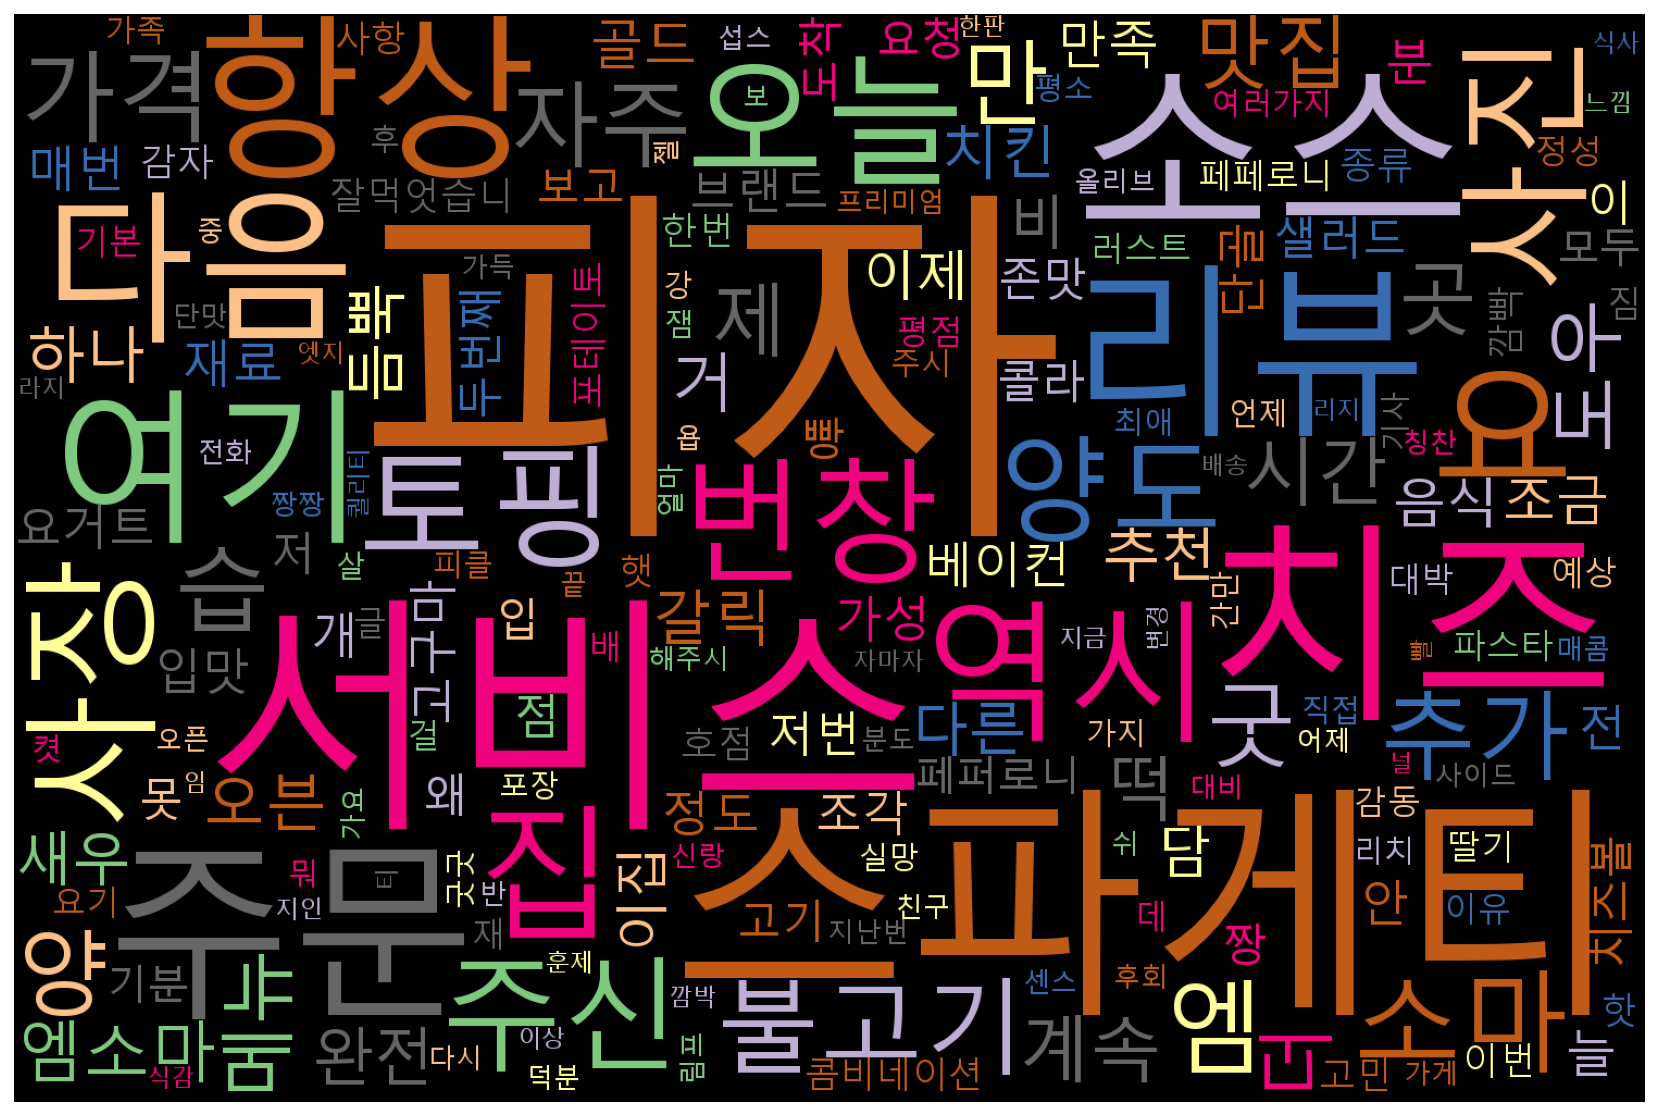

In [338]:
from wordcloud import WordCloud

wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='black',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(words) 
plt.figure(figsize = (15 , 10))
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()



In [339]:
df = pd.DataFrame(comments)
df

,0
0,정말맛있게먹었어요다음에는사진도올릴게요
1,맛있게 잘 먹었어요. 새우가 탱글하니 신선함이 느껴집니다^^
2,통통한팬피자...도우도맛있거 급히먹느라 사진깜박이지만 반반메뉴 너무좋아요 토핑...
3,매번 먹는곳이지만\n너무맛있게먹다보니 오자마자 사진찍는걸 까먹었어요ㅎㅎ\n진짜 이집...
4,너무 맛있었어요
...,...
758,오픈했다길래 호기심반 기대반으로 시켜봤어요~\n배달도 엄청 빠르게 와서 피자와 서비...
759,친절하고 맛이 있고 개업햇다고 스파개티도 챙겨 주시고 감사합니다
760,푸짐해요~~ 한조각 먹어도 배부르네요\n콤비네이션피자 아닌줄 알았어요\n토핑 진짜 ...
761,진짜 리뷰 처음 남기는데 양도 맛도 서비스도 최고입니다!! 덕분에 금요일 밤 배불리...


In [340]:
df = df.rename({0:'comment'},axis = 'columns')
df

,comment
0,정말맛있게먹었어요다음에는사진도올릴게요
1,맛있게 잘 먹었어요. 새우가 탱글하니 신선함이 느껴집니다^^
2,통통한팬피자...도우도맛있거 급히먹느라 사진깜박이지만 반반메뉴 너무좋아요 토핑...
3,매번 먹는곳이지만\n너무맛있게먹다보니 오자마자 사진찍는걸 까먹었어요ㅎㅎ\n진짜 이집...
4,너무 맛있었어요
...,...
758,오픈했다길래 호기심반 기대반으로 시켜봤어요~\n배달도 엄청 빠르게 와서 피자와 서비...
759,친절하고 맛이 있고 개업햇다고 스파개티도 챙겨 주시고 감사합니다
760,푸짐해요~~ 한조각 먹어도 배부르네요\n콤비네이션피자 아닌줄 알았어요\n토핑 진짜 ...
761,진짜 리뷰 처음 남기는데 양도 맛도 서비스도 최고입니다!! 덕분에 금요일 밤 배불리...


In [341]:
k = 0
for i in df['comment']:
    text = re.compile('[ㄱ-ㅎ|\d\ㅏ-ㅣ|가-힣]+').findall(i)
    df.loc[k, 'comment'] = ' '.join(text).strip()
    k+=1

In [342]:
from hanspell import spell_checker

def fix_sentence(row):
    spelled_sent = spell_checker.check(row)

    fixed_sent = spelled_sent.checked
    return fixed_sent


In [343]:
df['comment'] = df['comment'].apply(fix_sentence)
df

,comment
0,정말 맛있게 먹었어 요다음에는 사진도 올릴게요
1,맛있게 잘 먹었어요 새우가 탱글 하니 신선함이 느껴집니다
2,통통한 팬 피자 도우도 맛있게 급히 먹느라 사진 깜빡이지만 반반 메뉴 너무 좋아요 ...
3,매번 먹는 곳이지만 너무 맛있게 먹다 보니 오자마자 사진 찍는 걸 까먹었어요ㅎㅎ 진...
4,너무 맛있었어요
...,...
758,오픈했다길래 호기심 반 기대반으로 시켜봤어요 배달도 엄청 빠르게 와서 피자와 서비스...
759,친절하고 맛이 있고 개업했다고 스파게티도 챙겨 주시고 감사합니다
760,푸짐해요 한 조각 먹어도 배부르네요 콤비네이션 피자 아닌 줄 알았어요 토핑 진짜 실...
761,진짜 리뷰 처음 남기는데 양도 맛도 서비스도 최고입니다 덕분에 금요일 밤 배불리 잘...


In [545]:
def tokenizer(row):
    morphs = []
    morphs.append(okt.pos(row))
    
    
    req_tokens = []

    filter_words = ['좀', '담', '거', '것', '할', '하', '해', '한', '다음', '담', '짜리', '다른', '시켜','오늘', '매우'\
                   ,'짐', '다를', '왜', '안', '그래요', '무엇', '댓글', '식', '하나', '약간', '여기', '기도','말'\
                    ,'요즘','완전히','땐','란', '저희','우리','제','점','마','때','삼아', '한마디', '싶네요', '항상'\
                   ,'둘','전부','끼','하시고','있었어요','없었어요','하고','했던','중','정도','오게','더','사장님','앞'\
                   ,'게','정말','집','이','같습니다','사장','걸','번','전','건','보','같아요','진짜','두','처음','계속'\
                   ,'리뷰','입','개','가지','입니다','추가','주문','배달','서비스']
#     filter_words = ['너무', '좀', '근데', '양도', '어', '전', '흐']

    for sentence in morphs : 
        for word, tag in sentence : 
#             if (tag in ['Noun'] or tag in ['Verb'] or tag in ['Adjective']) and word not in filter_words: 
            if (tag in ['Noun'] or tag in ['Adjective']) and word not in filter_words: 
                req_tokens.append(word) 
    
#     return morphs
    return req_tokens

tokenizer('오랜만에 시켰는데 맛이 예전 같지 않네요. 비싸요. 홍합은 국물이 완전히 새서 왔어요 ㅜ')

['만', '맛', '예전', '같지', '비싸요', '홍합', '국물']

In [546]:
df['com_tokens'] = df['comment'].apply(tokenizer)
df

,comment,com_tokens
0,정말 맛있게 먹었어 요다음에는 사진도 올릴게요,"[맛있게, 요다음, 사진]"
1,맛있게 잘 먹었어요 새우가 탱글 하니 신선함이 느껴집니다,"[맛있게, 새우, 글, 하니, 신선함이]"
2,통통한 팬 피자 도우도 맛있게 급히 먹느라 사진 깜빡이지만 반반 메뉴 너무 좋아요 ...,"[통통한, 팬, 피자, 도우, 맛있게, 급히, 사진, 깜빡, 반, 메뉴, 좋아요, ..."
3,매번 먹는 곳이지만 너무 맛있게 먹다 보니 오자마자 사진 찍는 걸 까먹었어요ㅎㅎ 진...,"[매번, 곳, 맛있게, 자마자, 사진, 이집, 피자, 굳]"
4,너무 맛있었어요,[맛있었어요]
...,...,...
758,오픈했다길래 호기심 반 기대반으로 시켜봤어요 배달도 엄청 빠르게 와서 피자와 서비스...,"[오픈, 호기심, 반, 대반, 빠르게, 피자, 주신, 스파게티, 따뜻했어요, 맛있게..."
759,친절하고 맛이 있고 개업했다고 스파게티도 챙겨 주시고 감사합니다,"[친절하고, 맛, 있고, 개업, 스파게티, 주시]"
760,푸짐해요 한 조각 먹어도 배부르네요 콤비네이션 피자 아닌 줄 알았어요 토핑 진짜 실...,"[짐해, 조각, 배부르네요, 콤비네이션, 피자, 아닌, 줄, 토핑, 실하네요]"
761,진짜 리뷰 처음 남기는데 양도 맛도 서비스도 최고입니다 덕분에 금요일 밤 배불리 잘...,"[양도, 맛, 최고, 덕분, 금요일, 밤, 배, 불리]"


In [547]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = df['com_tokens'], size = 100, window = 5, min_count = 0, workers = 4, sg = 1)

In [548]:
model.wv.vectors.shape

(1355, 100)

In [549]:
model_result = model.wv.most_similar('피자')
print(model_result)

[('맛', 0.9994710683822632), ('소스', 0.9993500709533691), ('맛있어요', 0.9992629885673523), ('스파게티', 0.9991964101791382), ('치즈', 0.9991903305053711), ('불고기', 0.9991313815116882), ('맛있고', 0.9990414977073669), ('좋고', 0.99901282787323), ('토핑', 0.9989806413650513), ('번창', 0.9989179372787476)]


In [550]:
model_result = model.wv.most_similar('스파게티')
print(model_result)

[('피자', 0.9991965293884277), ('맛', 0.9991743564605713), ('소스', 0.9990441799163818), ('토핑', 0.9988800883293152), ('불고기', 0.9988703727722168), ('맛있어요', 0.9987902641296387), ('치킨', 0.9987826347351074), ('치즈', 0.9987446069717407), ('메뉴', 0.9986929893493652), ('맛있고', 0.9985755681991577)]


In [551]:
model_result = model.wv.most_similar('맛')
print(model_result)

[('피자', 0.9994711875915527), ('스파게티', 0.9991744160652161), ('불고기', 0.999101996421814), ('치즈', 0.9990530014038086), ('맛있어요', 0.9990182518959045), ('소스', 0.9989992380142212), ('토핑', 0.9989762902259827), ('또', 0.9989641904830933), ('사진', 0.9989042282104492), ('치킨', 0.9987931847572327)]


In [552]:
model_result = model.wv.most_similar('가격')
print(model_result)

[('피자', 0.9988082051277161), ('토핑', 0.9987693428993225), ('맛', 0.9985722303390503), ('치즈', 0.9985359907150269), ('맛있어요', 0.9984790086746216), ('맛있고', 0.9982807636260986), ('스파게티', 0.9982725381851196), ('메뉴', 0.9982336163520813), ('치킨', 0.998218834400177), ('번창', 0.9982142448425293)]


In [553]:
model_result = model.wv.most_similar('식감')
print(model_result)

[('오븐', 0.9734054803848267), ('치즈', 0.9733552932739258), ('좋았어요', 0.9732925891876221), ('골드', 0.9729015827178955), ('단맛', 0.9728123545646667), ('피자', 0.9725822806358337), ('사진', 0.9725468158721924), ('맛있네요', 0.9725426435470581), ('듬뿍', 0.9725161194801331), ('맛있게', 0.9724258184432983)]


In [554]:
model_result = model.wv.most_similar('치즈')
print(model_result)

[('피자', 0.9991903305053711), ('맛있어요', 0.9991334676742554), ('맛', 0.9990529417991638), ('맛있게', 0.9989532232284546), ('소스', 0.9989513158798218), ('불고기', 0.9987955689430237), ('스파게티', 0.9987446069717407), ('사진', 0.9987075328826904), ('또', 0.9986909627914429), ('곳', 0.9986403584480286)]


In [555]:
model_result = model.wv.most_similar('소스')
print(model_result)

[('피자', 0.9993501901626587), ('스파게티', 0.9990441799163818), ('맛', 0.9989992380142212), ('치즈', 0.9989513158798218), ('맛있어요', 0.9988291263580322), ('토핑', 0.9987046718597412), ('불고기', 0.9987013339996338), ('좋은', 0.9986317753791809), ('치킨', 0.9985085725784302), ('맛있고', 0.9984883069992065)]


In [15]:
def Sentiment_Analysis(list):
        # 디바이스 설정
    global device
    if torch.cuda.is_available():    
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')
    global model    
    model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
    model.cuda()

    PATH = './'
    model.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))

    global tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
    positive = []
    negative = []
    
    for i in list:
        logits = test_sentences([i])
        if np.argmax(logits) == 1:
            positive.append(i)
        elif np.argmax(logits) == 0:
            negative.append(i)
    return positive, negative    

In [16]:
positive_comments, negative_comments = Sentiment_Analysis(comments)

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [17]:
positive_comments

['뷔페가면 먹을 수 있는 족발 맛입니다 하지만 족발 빼고는 다 맛있었습니다',
 '중짜리 3명이 머꼬도 남았어요...가격도 착하구 맛도 정갈 깔끔하네요...보쌈고기도 퍽퍽하거나 비계가 만커나 하지않구 비율이 딱 조으네요..보쌈하면 생각날꺼 같아요',
 '맛있게 잘먹었습니다',
 '맛있게 잘 먹었습니다',
 '맛있어요~~~~~~',
 '배달이넘늣네여저시갓애안오고',
 '새우젓 주심 조을텐대',
 '냄새 안나요 양도 괜찮아요',
 '맛은괜찬은데 상추가 잘안씻어젔네요',
 '쟁반국수가 맛있어서 항상 여기서 주문해요\n보쌈도 족발도 항상 맛있는데 이번 보쌈은 좀 퍽퍽한식감이라서 아쉬웠습니다',
 '배달은 좀 늦었지만 맛은 있었어요.',
 '정말맛있습니다!  명품장충동외에는 안시켜먹어요',
 '맛있고 배달하시는분도 엄청 친절하시고!!!',
 '맛있어요 맛있어요',
 '처음먹는데먹을만해요..^^',
 '배달오신분 엄청 시크하네요\n문 세게두드리고 말 한마디도 안하고\nㄷㄷ',
 '이틀연속 주문할정도로 맛있음',
 '족발 보쌈 다 맛있네요',
 '가성비 갑 맛도 짱 어디집보다 좋습니다 ~~!',
 '김치에 굴이 들어가잇는거 보고 저희 아빠가 너무 좋아하셧어용ㅎㅎ 김치먹으려고 또 여기에 주문하게 생겻어요~ㅎㅎ',
 '시킬때마다 만족한듯',
 '처음시켜봤는데 양도많고 맛도좋고 대만족입니다 !!!',
 '족발보쌈운 무조건 여기가 갑입니다. 당근빼달랬더니 전부 빼주심 감덩',
 '진짜 배달도 빨리됬었구 맛있었어영',
 '음식 맛 배달다좋아요',
 '맛배달 짱입니다!!!!',
 '항상 맛있게 잘 먹고있어요  고맙습니다',
 '맛과 양 정말 최고입니다 항상 여기서만 먹어용',
 '배달은 조금 늦었지만 맛은 최고입니다.',
 '항상 만족하며 먹고 있습니다',
 '리얼 맛있어요 안비리고 맛 양 다 좋네요',
 '첨시켜보는데 맛있네요.. 먹느냐고  사진을 막찍었넉요!! 담에 또 시켜먹을께용ㅎ',
 '항상 잘 먹고있어요',
 '맛은 좀 아쉬워요ㅠ\n할인되서 주문했는데 무가 넘 썻어요ㅠ',

In [18]:
negative_comments

['오랜만에 시켰는데 맛이 예전같찌 않네요~\n홍합은 국물이 다 새서 왔어요~ㅜ',
 '여태까지 먹던중최고로 맛없어 다 \n버려버렷어요',
 '잘먹어서요 혼자먹기 모잘라지도않아서요',
 '배달이 늦게왓지만 맛은 조앗어요.막국수 양념은 맛잇는데 면에서 냄새가좀나네요',
 '와 ㅠㅠ  이가격이 이구성이!??!??',
 '음식맛과 양은 만족하였으나 배달원의 서비스착오로 좀 아쉬운점은 있었습니다',
 '음..약간맛이밍밍했어요',
 '보쌈은 김치맛으로 먹는데\n김치가 덜 맛있었어요\n배달은 35분 걸려어요',
 '너무 맛없어요... 예전이랑 맛이좀 다른듯....',
 '리뷰보고 처음시켰는데 맛나네요~\n다음에도 여기에서 시킬꺼같아요^^',
 '족발에서 냄새가 나요... 우울해서 기분풀려고 주문했는데 더 우울하네요....',
 '맛은 좋았구요^^ 양을 좀더 늘려주시면 좋을것 같습니다',
 '처음시켜먹었는데 다음에도',
 '너무찔겨서 그져그래요',
 '맛 양은 좋았으나 배달이 1시간 20분',
 '아 이정도가격에 이맛이면 가성비가 조쿠요 가조쿠 보이루!',
 '그렇게 먹고싶진않내요 배달특히 개느림 다른곳에서 먹을래요 걍',
 '개인적으로 맛이 별로엿네요...ㅜㅜ',
 '너무늦게옴 짜증날지경..;',
 '아니 밥 3개를 시켰는데 실수로 하나만 가져다 주지를 않나.. 상추에서 벌레가 나오지를 않나.. 무공해 상추라 그렇다고 김치 많이드렸으니 김치에다 싸서 드시라는데 진심 할 말을 잃었네요ㅎ 네.. 시켜드실 분들은 시켜드세요..ㅎ',
 '딱 보쌈만 맛있어요ㅠ\n청상추는 다 병기가 있어서 쌈해서먹을수가 없었어요.ㅠ\n돈 아까워',
 '대짜리 시켰는데 양이 대짜가 아닌거같네요..... 가끔족발 시켜서먹는데 보쌈은 아닌거같네여;;',
 '깔끔해요',
 '맛괜찮아서여기서자주시켜먹었는데\n점점맛없어짐\n이번엔최악이엿음..\n다신안시킴',
 '배달을 잘못가서 1시간 넘어서받았어요 족발 굵기도 일정하시안고 조금많이실망했네요',
 '두시간이 다되도 안와요\n별점도 아까워요. 성질나요',
 '

In [19]:
def make_wordcloud(list):
    okt = Okt() 
    morphs = [] 
    for sentence in list: 
        morphs.append(okt.pos(sentence))

    
    filter_words = ["다만", "껀", "먹기", "전체", "한지", "온", "생각", "별로", "맛", "배달", "도", "애", "두", "앞", "용", "때", "무조건", "좀", "꼭", "아주", "일단", "원래", "또", "것", "내", "나", "수", "게", "말", "진짜", "제일", "최고", "처음", "것", "정말", "이벤트", "매우", "번", "그냥", "이용"]
    noun_adj_adv_list=[]

    for sentence in morphs : 
        for word, tag in sentence : 
            if tag in ['Noun'] and word not in filter_words: 
                noun_adj_adv_list.append(word) 
                
    count = Counter(noun_adj_adv_list)
    words = dict(count.most_common())
    
    matplotlib.rc('font',family = 'Malgun Gothic')
    set_matplotlib_formats('retina')
    matplotlib.rc('axes',unicode_minus = False)
    
    wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(words) 
    plt.imshow(wordcloud) 
    plt.axis('off') 
    return plt.show()

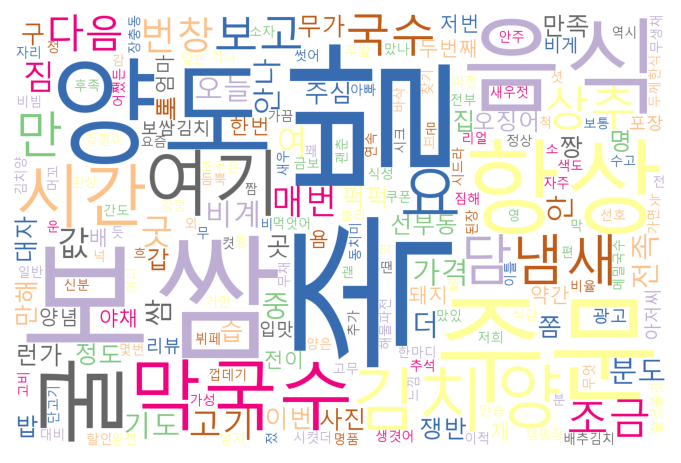

In [20]:
make_wordcloud(positive_comments)

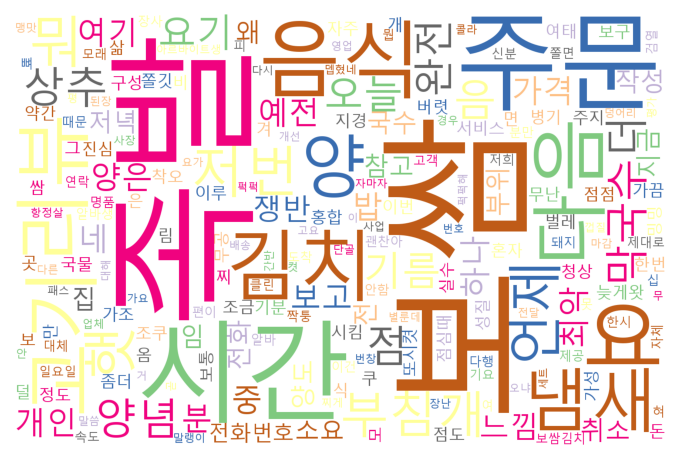

In [21]:
make_wordcloud(negative_comments)

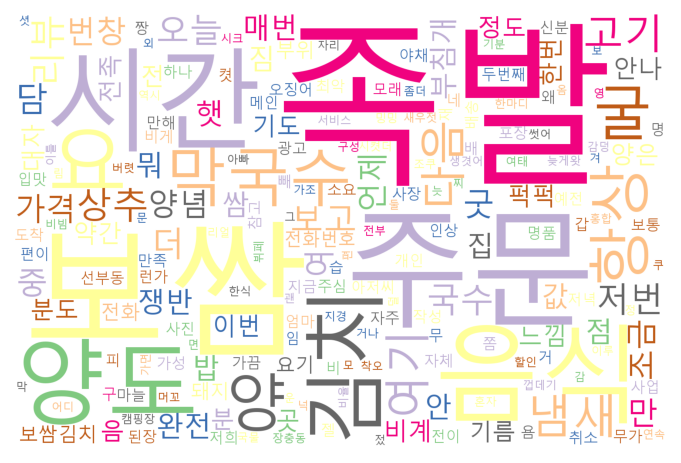

In [22]:
make_wordcloud(comments)

In [213]:
twitter.add_dictionary('은경이', 'Noun')

In [214]:
okt.morphs('은경이는 사무실로 갔습니다.')

['은경', '이', '는', '사무실', '로', '갔습니다', '.']

In [192]:
from hanspell import spell_checker

sent = "담에 또 시켜먹을게요"
spelled_sent = spell_checker.check(sent)

hanspell_sent = spelled_sent.checked
print(hanspell_sent)

담에 또 시켜 먹을게요


In [209]:
sent = '오랜만에 시켰는데 빨리 맛이 예전 같지 않네요 홍합은 국물이 다 새서 왔어요 ㅜ'

In [143]:
sent = '짐,다를,삼아,약간,완전히'

In [210]:
from konlpy.tag import Okt  
okt=Okt()  
print(okt.morphs(sent))

['오랜', '만', '에', '시켰는데', '빨리', '맛', '이', '예전', '같지', '않네요', '홍합', '은', '국물', '이', '다', '새서', '왔어요', 'ㅜ']


In [144]:
print(okt.pos(sent)) 

[('짐', 'Noun'), (',', 'Punctuation'), ('다를', 'Adjective'), (',', 'Punctuation'), ('삼아', 'Verb'), (',', 'Punctuation'), ('약간', 'Noun'), (',', 'Punctuation'), ('완전히', 'Adjective')]


In [207]:
from hanspell import spell_checker

spelled_sent = spell_checker.check(sent)

hanspell_sent = spelled_sent.checked
print(hanspell_sent)

오랜만에 시켰는데 빨리 맛이 예전 같지 않네요 홍합은 국물이 다 새서 왔어요 ㅜ
